In [3]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import random
import math
import sys

#### OLS_all

In [4]:
df_tr = pd.read_csv("ML_FP_train.csv")
df_tr = df_tr.drop(['Album_type', 'Licensed', 'official_video', 'Track', 'Album', \
    'Uri', 'Url_spotify', 'Url_youtube', 'Comments', 'Description', 'Title', \
    'Channel', 'Composer', 'Artist'], axis=1)
df_t = pd.read_csv("ML_FP_test.csv")
df_t = df_t.drop(['Album_type', 'Licensed', 'official_video', 'Track', 'Album', \
    'Uri', 'Url_spotify', 'Url_youtube', 'Comments', 'Description', 'Title', \
    'Channel', 'Composer', 'Artist'], axis=1)

# df_tr.shape (17170, 29)
# random_rows = df_tr.sample(n=10)
# print(random_rows)
print(df_tr.columns)

df_tr = df_tr.fillna(df_tr.median()) #處理缺失值
df_tr = df_tr.astype({"Danceability":"int", "Views":"int", "Likes":"int", "Stream":"int"})
df_t = df_t.fillna(df_t.median()) #處理缺失值
df_t = df_t.astype({"Views":"int", "Likes":"int", "Stream":"int"})

Index(['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Views', 'Likes', 'Stream', 'id'],
      dtype='object')


In [5]:
# df_tr = df_tr.fillna(0) #處理缺失值
# df_tr = df_tr.astype({"Danceability":"int", "Views":"int", "Likes":"int", "Stream":"int"})
# df_t = df_t.fillna(0) #處理缺失值
# df_t = df_t.astype({"Views":"int", "Likes":"int", "Stream":"int"})

dep_var = 'Danceability'
indep_var = ['Energy', 'Key', 'Loudness', 'Speechiness','Acousticness',\
     'Instrumentalness', 'Liveness', 'Valence', 'Tempo','Duration_ms', 'Views', 'Likes', 'Stream']

y_tr = df_tr[dep_var]
X_tr = df_tr[indep_var]
X_t = df_t[indep_var]

# Standardize the input features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_t_scaled = scaler.transform(X_t)

# with statsmodels
X_tr = sm.add_constant(X_tr) # adding a constant
X_t = sm.add_constant(X_t)
X_tr_scaled = sm.add_constant(X_tr_scaled) # adding a constant
X_t_scaled = sm.add_constant(X_t_scaled)

ols_model = sm.OLS(y_tr, X_tr).fit()
ols_std_model = sm.OLS(y_tr, X_tr_scaled).fit()

ols_predictions_t = ols_model.predict(X_t) 
# Round the predicted values to the nearest integer and convert to integers
ols_predictions_t = ols_predictions_t.round().astype(int)
# Map the predicted values to the range {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ols_predictions_t = ols_predictions_t.clip(0, 9)

print_ols_model = ols_model.summary()
print(print_ols_model)

ols_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': ols_predictions_t})
ols_predictions_df.to_csv('ols_all_submission.csv', index=False)

                            OLS Regression Results                            
Dep. Variable:           Danceability   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     527.7
Date:                Thu, 18 May 2023   Prob (F-statistic):               0.00
Time:                        20:15:31   Log-Likelihood:                -39512.
No. Observations:               17170   AIC:                         7.905e+04
Df Residuals:                   17156   BIC:                         7.916e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.4988      0.126  

In [20]:
# Fit the robust OLS model
robust_model = sm.RLM(y_tr, X_tr_scaled, M=sm.robust.norms.HuberT())
robust_results = robust_model.fit()

ols_scaled_t = robust_results.predict(X_t_scaled)
# Round the predicted values to the nearest integer and convert to integers
ols_scaled_t = ols_scaled_t.round().astype(int)
# Map the predicted values to the range {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ols_scaled_t = ols_scaled_t.clip(0, 9)

print_ols_std_model = ols_std_model.summary()
print(print_ols_std_model)

ols_scaled_df = pd.DataFrame({'id': df_t['id'], 'Danceability': ols_scaled_t})
ols_scaled_df.to_csv('ols_scaled_robust_submission.csv', index=False)

                            OLS Regression Results                            
Dep. Variable:           Danceability   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     527.7
Date:                Thu, 18 May 2023   Prob (F-statistic):               0.00
Time:                        19:01:38   Log-Likelihood:                -39512.
No. Observations:               17170   AIC:                         7.905e+04
Df Residuals:                   17156   BIC:                         7.916e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5860      0.018    248.590      0.0

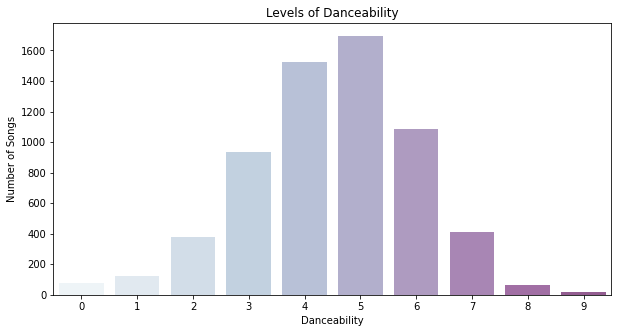

In [21]:
ols_predictions_df["Danceability"] = ols_predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=ols_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

ols_predictions_df["Danceability"] = ols_predictions_df["Danceability"].astype("int")

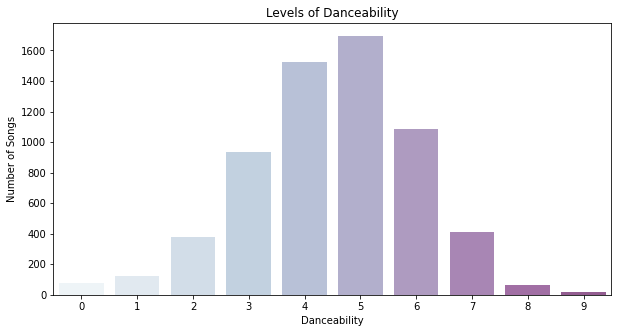

In [19]:
ols_scaled_df["Danceability"] = ols_scaled_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=ols_scaled_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

###### Score: 2.10547 (fillna = median)

In [11]:
dep_var = 'Danceability'
indep_var = ['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness',
             'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Stream']

y_tr = df_tr[dep_var]
X_tr = df_tr[indep_var]
X_t = df_t[indep_var]

# Convert 'Danceability' to categorical classes
y_tr_categorical = y_tr.round().astype(int)
y_tr_categorical = y_tr_categorical.clip(0, 9)

# with statsmodels using multinomial logistic regression
X_tr = sm.add_constant(X_tr)  # adding a constant
X_t = sm.add_constant(X_t)
mlogit_model = sm.MNLogit(y_tr_categorical, X_tr).fit()

mlogit_predictions_t = mlogit_model.predict(X_t)
# Convert the predicted probabilities to class labels
mlogit_predictions_t = mlogit_predictions_t.idxmax(axis=1)

mlogit_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': mlogit_predictions_t})
mlogit_predictions_df.to_csv('mlogit_all_submission.csv', index=False)

print_mlogit_model = mlogit_model.summary()
print(print_mlogit_model)

Optimization terminated successfully.
         Current function value: 2.103471
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:           Danceability   No. Observations:                17170
Model:                        MNLogit   Df Residuals:                    17044
Method:                           MLE   Df Model:                          117
Date:                Thu, 18 May 2023   Pseudo R-squ.:                 0.08597
Time:                        18:34:05   Log-Likelihood:                -36117.
converged:                       True   LL-Null:                       -39513.
Covariance Type:            nonrobust   LLR p-value:                     0.000
  Danceability=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1563      0.232     -0.673      0.501      -0.612       0.299
Energy     

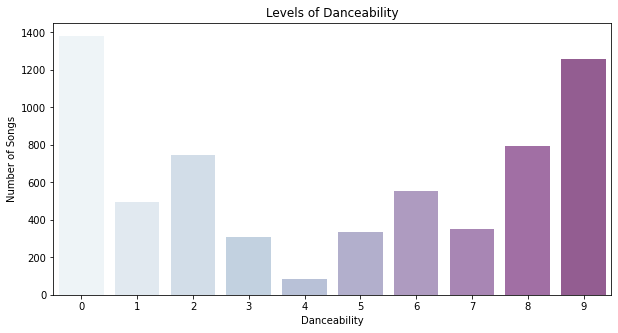

In [12]:
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=mlogit_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

mlogit_predictions_df["Danceability"] = mlogit_predictions_df["Danceability"].astype("int")

#### OLS_Ridge

In [8]:
from sklearn.linear_model import Ridge

# Perform Ridge regression
alpha = 0.5  # Regularization parameter
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_tr_scaled, y_tr)

# Make predictions on the test data
ridge_predictions_t = ridge_model.predict(X_t_scaled)
# Round the predicted values to the nearest integer and convert to integers
ridge_predictions_t = ridge_predictions_t.round().astype(int)
# Map the predicted values to the range {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ridge_predictions_t = ridge_predictions_t.clip(0, 9)

ridge_model_summary = "Ridge Regression Model (alpha={})\n".format(alpha)
ridge_model_summary += "Coefficient of determination (R-squared): {:.4f}\n".format(ridge_model.score(X_tr_scaled, y_tr))
ridge_model_summary += "Intercept: {:.4f}\n".format(ridge_model.intercept_)
ridge_model_summary += "Coefficients:\n"
for feature, coefficient in zip(X_tr.columns, ridge_model.coef_):
    ridge_model_summary += "- {}: {:.4f}\n".format(feature, coefficient)

print(ridge_model_summary)

ridge_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': ridge_predictions_t})
ridge_predictions_df.to_csv('ridge_submission.csv', index=False)

Ridge Regression Model (alpha=0.5)
Coefficient of determination (R-squared): 0.2856
Intercept: 4.5860
Coefficients:
- const: 0.0000
- Energy: -0.4541
- Key: 0.0356
- Loudness: 0.3567
- Speechiness: 0.4911
- Acousticness: -0.5043
- Instrumentalness: -0.0623
- Liveness: -0.2158
- Valence: 1.0078
- Tempo: -0.4225
- Duration_ms: -0.1986
- Views: 0.0468
- Likes: 0.1460
- Stream: 0.0545



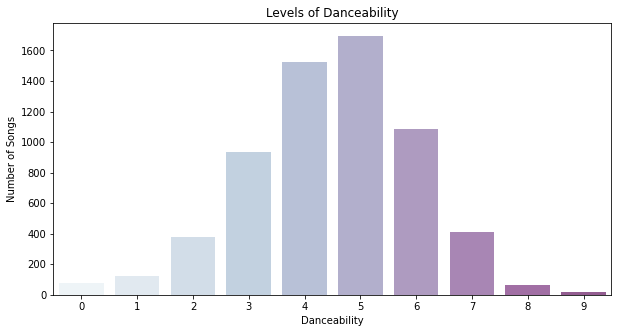

In [9]:
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=ridge_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

ridge_predictions_df["Danceability"] = ridge_predictions_df["Danceability"].astype("int")

#### Neural Network Classifier

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

dep_var = 'Danceability'
indep_var = ['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness',
             'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Stream']

# Prepare the data
X_tr = df_tr[indep_var]
X_t = df_t[indep_var]
y_tr = df_tr[dep_var]

# Standardize the input features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_t_scaled = scaler.transform(X_t)

# Create the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(indep_var),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_tr_scaled, y_tr, epochs=10, batch_size=32)

# Use the trained model to predict y_t
predictions = model.predict(X_t_scaled)
predicted_classes = predictions.argmax(axis=1)

# Create a dataframe with the predictions
predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': predicted_classes})

# Save the predictions to a CSV file
predictions_df.to_csv('neural_network_submission.csv', index=False)

Epoch 1/10
537/537 [==============================] - 2s 2ms/step - loss: 2.1352 - accuracy: 0.1941
Epoch 2/10
537/537 [==============================] - 1s 2ms/step - loss: 2.0451 - accuracy: 0.2227: 
Epoch 3/10
537/537 [==============================] - 1s 2ms/step - loss: 2.0186 - accuracy: 0.2324: 0s - loss: 2.0205 - accuracy
Epoch 4/10
537/537 [==============================] - 1s 2ms/step - loss: 2.0053 - accuracy: 0.2429
Epoch 5/10
537/537 [==============================] - 1s 2ms/step - loss: 1.9953 - accuracy: 0.2474
Epoch 6/10
537/537 [==============================] - 1s 3ms/step - loss: 1.9873 - accuracy: 0.2489
Epoch 7/10
537/537 [==============================] - 1s 2ms/step - loss: 1.9816 - accuracy: 0.2503
Epoch 8/10
537/537 [==============================] - 1s 2ms/step - loss: 1.9752 - accuracy: 0.2535
Epoch 9/10
537/537 [==============================] - 1s 2ms/step - loss: 1.9687 - accuracy: 0.2552
Epoch 10/10
537/537 [==============================] - 1s 2ms/step -

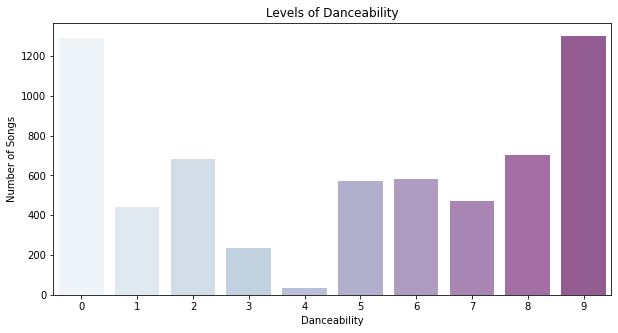

In [14]:
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

predictions_df["Danceability"] = predictions_df["Danceability"].astype("int")

#### SVM

In [22]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# Create an SVM classifier
svm = SVC(kernel='linear')

# Create the RFE object and specify the number of desired features
num_features = 5  # Specify the number of features you want to select
rfe = RFE(estimator=svm, n_features_to_select=num_features)

# Fit the RFE object to the training data
rfe.fit(X_tr, y_tr)

# Get the selected features
selected_features = [indep_var[i] for i, selected in enumerate(rfe.support_) if selected]

# Print the selected features
print("Selected Features:")
print(selected_features)